In [443]:
# Import necessary modules:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, r2_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
print(__doc__)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from itertools import product

Automatically created module for IPython interactive environment


# 1. Cleaning and Exploratory Data Analysis:

In [444]:
# Read three datasets. Rename email_id columns in email_opened_table and link_clicked_table to make it easier
# for an outer merge later:
email_1 = pd.read_csv('email_table.csv')
email_2 = pd.read_csv('email_opened_table.csv').rename(columns={'email_id':'opened'})
email_3 = pd.read_csv('link_clicked_table.csv').rename(columns={'email_id':'clicked'})

In [445]:
# Merge email_2 and email_3 with email_1, which includes all metadata necessary for modeling: 
email = email_1.merge(email_2, left_on='email_id', right_on='opened', how='outer')
emails = email.merge(email_3, left_on='email_id', right_on='clicked', how='outer')

In [446]:
# Transform email_id and NaN values in opened and clicked to 0 (NaN) and 1 for any other non-null values. 
# NaN means the email has not beened opened or the linked not clicked. 1 means vice versa:
emails['opened'] = emails['opened'].apply(lambda x: 1 if not pd.isnull(x) else 0)
emails['clicked'] = emails['clicked'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [447]:
# Drop all duplicates if existed:
emails = emails.drop_duplicates()

In [448]:
# Remove email_id as it's not necessary for the analysis (in this project):
emails = emails.drop(['email_id'], axis=1)

In [449]:
# Take a look at the dataset after merging and some preprocessing: 
emails.head(2)

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,short_email,personalized,2,Sunday,US,5,0,0
1,long_email,personalized,12,Sunday,UK,2,1,1


In [450]:
# Check if all emails are opened before the link clicked:
non_sense = emails[(emails['opened'] == 0) & (emails['clicked'] == 1)]
non_sense.head(2)

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
3156,long_email,generic,14,Friday,US,7,0,1
3527,short_email,generic,14,Saturday,US,4,0,1


There are 50 links clicked before the email gets opened. There might be something wrong in the data entry process. The safest choice here is to drop all these observations.

In [451]:
# Drop nonsense observations from the dataframe:
emails.drop(emails[(emails['opened'] == 0) & (emails['clicked'] == 1)].index, inplace=True)

In [452]:
# Describe the dataset to check if there's still other nonsense observations.
# Hour ranges from 1 to 24. This makes sense, so it's unnecessary to change or remove any row. User past purchases
# also range from 0 to 22, which seems fine for now:
print(emails.describe())

               hour  user_past_purchases        opened      clicked
count  99950.000000         99950.000000  99950.000000  99950.00000
mean       9.059100             3.878559      0.103502      0.02070
std        4.439618             3.196324      0.304615      0.14238
min        1.000000             0.000000      0.000000      0.00000
25%        6.000000             1.000000      0.000000      0.00000
50%        9.000000             3.000000      0.000000      0.00000
75%       12.000000             6.000000      0.000000      0.00000
max       24.000000            22.000000      1.000000      1.00000


Every time an email is opened or a link clicked, opened and clicked columns sum would accumulate by 1.
Hence, there is about 10.35 percent of total emails sent get opened. Approximately, 2.12 percent of total 
emails sent get opened and the linked inside clicked.

=> These low percentages of opened emails and clicked links suggest a servere class imbalance that we have to deal with later.


In [453]:
# Check if there is any missing observations: 
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99950 entries, 0 to 99999
Data columns (total 8 columns):
email_text             99950 non-null object
email_version          99950 non-null object
hour                   99950 non-null int64
weekday                99950 non-null object
user_country           99950 non-null object
user_past_purchases    99950 non-null int64
opened                 99950 non-null int64
clicked                99950 non-null int64
dtypes: int64(4), object(4)
memory usage: 6.9+ MB


In [454]:
# Check if the number of emails sent to different countries are the same:
emails.groupby('user_country').count()

,email_text,email_version,hour,weekday,user_past_purchases,opened,clicked
user_country,,,,,,,
ES,9964,9964,9964,9964,9964,9964,9964
FR,9989,9989,9989,9989,9989,9989,9989
UK,19928,19928,19928,19928,19928,19928,19928
US,60069,60069,60069,60069,60069,60069,60069


This is perhaps a campaign targeting mainly US customers. ES and FR are pretty much the same in terms of the number of emails sent.

Text(0.5,1,'Click Rate by Hour')

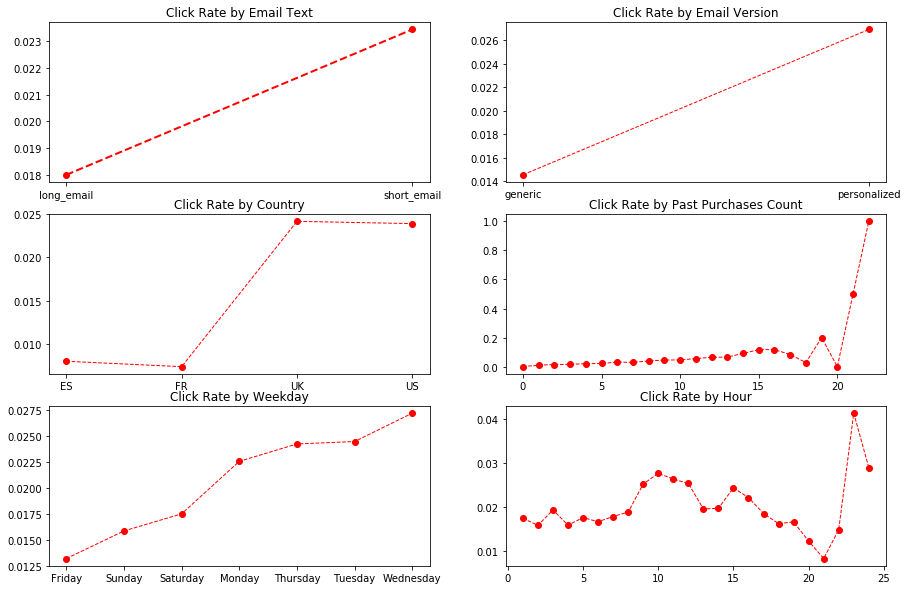

In [455]:
# Visualize the relationship of each feature with the target 
#(percentage of emails opened and the link inside clicked):

# Percentage of click counts by long and short email text.
# Use mean method because the number of emails sent to different customer segments and countries are different 
# (Total count would be biased then.)
text = emails.groupby('email_text')['clicked'].mean() 
version = emails.groupby('email_version')['clicked'].mean()
country = emails.groupby('user_country')['clicked'].mean()
purchases = emails.groupby('user_past_purchases')['clicked'].mean()
weekday_1 = pd.DataFrame(emails.groupby('weekday')['clicked'].mean()).sort_values(by=['clicked'])
weekday = weekday_1['clicked']
hour = emails.groupby('hour')['clicked'].mean()

plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
plt.plot(text, color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=6)
plt.title('Click Rate by Email Text')

plt.subplot(3,2,2)
plt.plot(version, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Email Version')

plt.subplot(3,2,3)
plt.plot(country, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Country')

plt.subplot(3,2,4)
plt.plot(purchases, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Past Purchases Count')

plt.subplot(3,2,5)
plt.plot(weekday_1, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Weekday')

plt.subplot(3,2,6)
plt.plot(hour, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Hour')

1. More short emails get opened and the link inside clicked. This is understandable. Most people don't have too much time reading advertising emails. Hence, it's faster and more tempting to get to the link in a short one. 
2. Personalized emails get opened and the link inside clicked much more often. 
3. The company mainly focuses on US and UK markets. Most emails are sent to customers in these countries.
ES and FR markets are doing very poorly in terms of click rate.
4. Though the number of emails sent to US customers tops the list among four countries (approximately three times the number of emails sent to UK customers). However, the UK customers seem more active with the highest click rate.
5. New customers don't often open and click the link inside their emails. Returners, especially those with more than 5 past purchases are more likely to click the link.
6. There are several outliners in click rate by past purchases counts. Customers with more than about 22 past purchases always open the link inside their email. This takes further investigation.
7. Customers are more likely to open link inside their emails during weekdays. Friday bottoms the list of click rate by weekday. This is understandatble. 
8. The click rate is highest from 10-16 everyday. Combined with the previous insihgt, it seems that most customers check advertising emails and open ad links at work. This can be a valuable insight for the content creation and marketing teams. 
9. There are also outliners when it comes to click rate by hour. At 11PM, the click rate is much higher than earlier in the day. This needs further investigation.

In [456]:
# Take a look at returners with higher than 20 past purchases:
emails[emails['user_past_purchases'] > 20]

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
5123,long_email,personalized,16,Monday,US,22,1,1
10366,long_email,generic,12,Monday,US,21,0,0
13885,long_email,generic,14,Tuesday,FR,21,1,1
24535,short_email,personalized,9,Tuesday,UK,21,0,0
32881,short_email,generic,7,Wednesday,UK,21,1,1


They have much higher click rate than the overall rate but the group is only of 5. 

In [457]:
# Take a look at customers clicking provided link very late:
print(emails[emails['hour'] > 22]['clicked'].mean())
print(emails[emails['hour'] > 22]['clicked'].count())

0.037383177570093455
214


Though the click rate at 23 is much higher than earlier hours in the day, there are only 145 customers have this behavior.
So there is not really a pattern that we can exploit here.

In [458]:
# Because outliers of both features - hour and user purchases - do not contain meaningful patterns, 
# I remove them here. Just to prevent the case outliers severely skew the CTR (click through rate):
emails = emails[(emails['user_past_purchases'] < 20) & (emails['hour'] < 22)]

In [461]:
# Create a copy of the dataset in case it would be helpful later:
emails_1 = emails.copy()

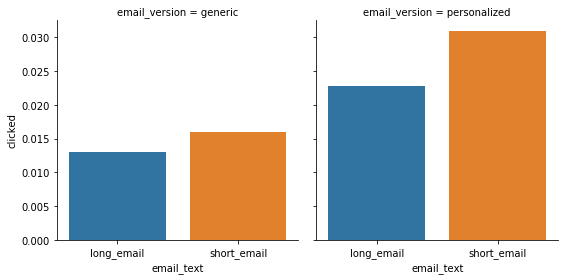

In [462]:
# Short email and personalized email separately increase click rate. Check the interaction between these
# two features:
fg = sns.factorplot(x='email_text', 
                    y='clicked',
                    col='email_version', 
                    data=emails.groupby(['email_text', 'email_version'])['clicked'].mean().to_frame().reset_index(), 
                    kind='bar')

Personalized short emails are those with highest click rate. It might be helpful to create an interaction feature of these two features.

# 2. Prepare Data for Analysis

In [463]:
# I will use gradient boosting and decision tree models later. Hence, it's suitable to label encode 
# several features in the dataset:
le = LabelEncoder()
emails['email_text'] = le.fit_transform(emails['email_text'])
emails['email_version'] = le.fit_transform(emails['email_version'])
emails['weekday'] = le.fit_transform(emails['weekday'])
emails['user_country'] = le.fit_transform(emails['user_country'])

In [464]:
# Create the interaction feature of text_version and email_text
emails['text_version'] = emails['email_text'] * emails['email_version']

In [465]:
# Take a look at the dataset now:
emails.head(2)

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,text_version
0,1,1,2,6,3,5,0,0,1
1,0,1,12,6,2,2,1,1,0


In [466]:
# Create features and labels for classification models:
X = emails.drop(['clicked', 'opened'], axis=1)
y = emails[['clicked']]

In [467]:
# Now I need to cope with the severe class imbalance problem. For decision tree, I can easily increase
# class weight of underrepresented class later. For gradient boosting classifer, the simplest and safest choice
# here would be randomly under-sample the dataset:
rus = RandomUnderSampler(random_state=43)
X_res, y_res = rus.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 2055, 1: 2055})


/Users/tapham18/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tapham18/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Now I have a dataset composed equally of classes 0 and 1. X_rest and y_res are series, so I need to transform
# them into pandas dataframes:
X_1 = pd.DataFrame(X_res, columns = X.columns)
y_1 = pd.DataFrame(y_res, columns = y.columns)

In [ ]:
# Separate train and test sets with normal tran_test_split because there's no longer class imbalance in X_1 and y_1:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.3, random_state=43)

# 3. Modeling

# Gradient Boosting Classifier

In [470]:
# Instantiate the gradient boosting classifer:
gbc = GradientBoostingClassifier(learning_rate=0.2, random_state=1)
# Fit the classifier to X_train and y_train:
gbc.fit(X_train, y_train)
# Predict clicked class for X_test:
p = gbc.predict(X_test)

/Users/tapham18/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/tapham18/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


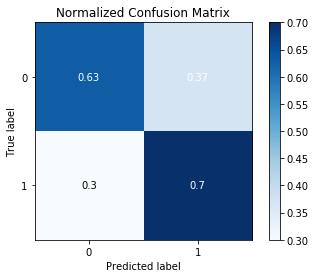

In [472]:
# Plot a confusion matrix to see how the classifier does:
skplt.metrics.plot_confusion_matrix(y_test, p, normalize=True)

Gradient boosting classifier does a decent job in this case. I mainly care about the true positive rate (1:1). True positive rate is 0.7, which is acceptable in the industry. Also, true negative rate in this case is not particularly low. 

For the acceptable results above, I can move on the see how clicked or not depends on different features in the models.

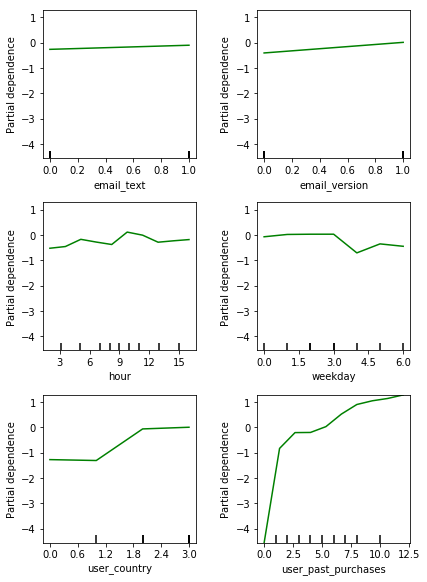

<Figure size 720x7200 with 0 Axes>

In [473]:
# Plot the partial dependence plot:
def main():
    names = X.columns
    features = [0, 1, 2, 3, 4, 5]
    fig, axs = plot_partial_dependence(gbc, X_train, features,
                                       feature_names=names,
                                       n_cols=2,
                                       n_jobs=3, grid_resolution=10)
    
    plt.subplots_adjust(top=2) 
    fig = plt.figure(figsize = (10,100))
    fig.suptitle('Partial dependence of CTR on controllable factors')
    plt.show()

if __name__ == '__main__':
    main()

- The partial dependence plot once again confirms my initial observations. 
- Links in short and personalized emails are more likely to get clicked. 
- Most links are clicked around 9-10AM on Tuesday-Wednesday. 
- ES and FR does poorly in terms of CTR while UK and US do fairly well.
- The more purchases a customer placed in the past, the more likely s/he would click on links received. Interestingly, this tendency is steeper for recent customers ( fewer than 4 purchases).
- User past purchases and user country are two features that I indeed don't have control of. 

# Decision Tree

In [474]:
# It's also helpful to run a simple decision tree to validate the results of the gradient boosting classifer
# without two features that I don't have control of.
# Decision tree classifier can be applied to the emails dataset at its original scale. 
# However, because two classes are severely imbalanced, I use Stratefied Shuffle Split 
# to shuffle observations and preserve the percentage of classes similar to that in the original dataset.
# This would obviate the situation when all and disproportionately many 1 class observations get divided 
# in either training or test set, which hinders the prediction of the important label.

# This time, I drop two features
X_2 = emails.drop(['clicked', 'opened', 'user_country', 'user_past_purchases'], axis=1)
sss.get_n_splits(X_2, y)
 
for train_index, test_index in sss.split(X_2, y):
    X_train_1, X_test_1 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]

# Check the ratio of two classes in test set:
y_test_1['clicked'].value_counts()

0    29239
1      617
Name: clicked, dtype: int64

In [475]:
# Build a simple tree to double check the prediction. Pre-prune the tree by limiting max_depth 
# to avoid overfitting:
dt = DecisionTreeClassifier(max_depth = 4, class_weight = {0:1,1:50})
dt.fit(X_train_1, y_train_1)
y_pred_2 = dt.predict(X_test_1)

/Users/tapham18/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


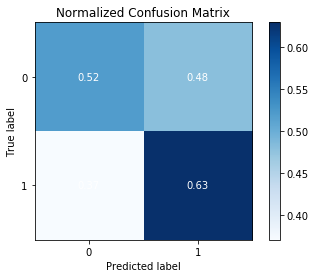

In [476]:
# Create a confustion matrix for the tree:
skplt.metrics.plot_confusion_matrix(y_test_1, y_pred_2, normalize=True)

A simple decision tree does not perform as well as gradient boosting classifier yielding only 0.52 true negative rate and 0.63 true positive rate. However, I mostly care about true positive rate and 0.63 is a decent number. Let's take a look at the tree nodes.

In [477]:
# Print root and top nodes of the tree:
tree.export_graphviz(dt, out_file='trees.dot', max_depth = 5, feature_names = X_2.columns) 

1. A shallow tree confirms that email version, weekday, and hour are all very informative.
2. Personalized emails sent on weekdays after 8.5 AM are more likely to have the links get clicked.

# Personalization:

Now, I don't have control of the number of past purchases or the user countries. The only thing I could do to improve the email campaign's effectiveness is to send 'smarter' emails. Hence, I would personalize the adjustable features of emails sent to different customer segments with the help of gradient boosting model.

In [ ]:
# Create 6 lists of values of all features I have:
email_text = emails.email_text.unique()
email_version = emails.email_version.unique()
hour = emails.hour.unique()
weekday = emails.weekday.unique()
user_past_purchases = emails.user_past_purchases.unique()
user_country = emails.user_country.unique()

In [546]:
# Create a dataframe of all combinations of different features values called testing:
testing = pd.DataFrame(list(product(email_text, email_version, hour, weekday, user_past_purchases, user_country)), 
                       columns=['email_text', 'email_version', 'hour', 'weekday', 'user_past_purchases', 'user_country'])
# Create an interaction feature between text_version and email_text so that it would be comparable with the data
# I have used to build the boosting model:
testing['text_version'] = testing['email_text'] * testing['email_version']

In [547]:
# Take a look at the testing dataset:
testing.head(5)

,email_text,email_version,hour,weekday,user_past_purchases,user_country,text_version
0,0,0,2,0,5,0,0
1,0,0,2,0,5,1,0
2,0,0,2,0,5,2,0
3,0,0,2,0,5,3,0
4,0,0,2,0,2,0,0


In [548]:
# Use the boosting model to predict whether a customer would click on the link after receive the email. Add those
# predictions to the testing dataset:
testing['predictions'] = gbc.predict(testing)

In [ ]:
# Create a dataframe for recent customers (fewer than 4 purchases) in Spain:
testing1 = testing[(testing['user_past_purchases']<4) & (testing['user_country'] == 0)]
# Create a dataframe for returning customers (more than 4 purchases) in Spain:
testing2 = testing[(testing['user_past_purchases']>4) & (testing['user_country'] == 0)]
# Create a dataframe for recent customers (fewer than 4 purchases) in France:
testing3 = testing[(testing['user_past_purchases']<4) & (testing['user_country'] == 1)]
# Create a dataframe for returning customers (more than 4 purchases) in France:
testing4 = testing[(testing['user_past_purchases']>4) & (testing['user_country'] == 1)]
# Create a dataframe for recent customers (fewer than 4 purchases) in the UK:
testing5 = testing[(testing['user_past_purchases']<4) & (testing['user_country'] == 2)]
# Create a dataframe for returning customers (more than 4 purchases) in the UK:
testing6 = testing[(testing['user_past_purchases']>4) & (testing['user_country'] == 2)]
# Create a dataframe for recent customers (fewer than 4 purchases) in the US:
testing7 = testing[(testing['user_past_purchases']<4) & (testing['user_country'] == 3)]
# Create a dataframe for returning customers (more than 4 purchases) in the US:
testing8 = testing[(testing['user_past_purchases']>4) & (testing['user_country'] == 3)]

In [ ]:
# Define a function that would return the best hour, weekday, email_text, and email_version to maximize 
# click through rate at different customer segments:
def optimal(data):
    # In the worst case, no one clicks on the link:
    if data.predictions.nunique() == 1:
        print('No recipient clickes links included in emails')
    else:
        print('The optimal day to send emails is:', data.groupby(['weekday'])['predictions'].mean().idxmax()) 
        print('The optimal hour to send emails is:', data.groupby(['hour'])['predictions'].mean().idxmax()) 
        print('The optimal email_text is:', data.groupby(['email_text'])['predictions'].mean().idxmax())
        print('The optimal email_version is:', data.groupby(['email_version'])['predictions'].mean().idxmax())

In [ ]:
# The company is doing very poorly in Spain:
optimal(testing1)

In [ ]:
optimal(testing2)

In [32]:
# Best time and email details to send to recent customers in France:
optimal(testing3)

The optimal day to send emails is: 3
The optimal hour to send emails is: 15
The optimal email_text is: 1
The optimal email_version is: 1


In [33]:
# Best time and email details to send to returning customers in France:
optimal(testing4)

The optimal day to send emails is: 3
The optimal hour to send emails is: 10
The optimal email_text is: 1
The optimal email_version is: 1


In [34]:
# Best time and email details to send to recent customers in the UK:
optimal(testing5)

The optimal day to send emails is: 5
The optimal hour to send emails is: 10
The optimal email_text is: 1
The optimal email_version is: 1


In [35]:
# Best time and email details to send to returning customers in the UK:
optimal(testing6)

The optimal day to send emails is: 3
The optimal hour to send emails is: 21
The optimal email_text is: 1
The optimal email_version is: 1


In [36]:
# Best time and email details to send to recent customers in the US:
optimal(testing7)

The optimal day to send emails is: 1
The optimal hour to send emails is: 10
The optimal email_text is: 1
The optimal email_version is: 1


In [37]:
# Best time and email details to send to returning customers in the US:
optimal(testing8)

The optimal day to send emails is: 2
The optimal hour to send emails is: 21
The optimal email_text is: 1
The optimal email_version is: 1


# 4. Product Recommendations:

1. The campaign is doing fine with US and UK markets. However, we need to figure out why we are doing so poorly in ES and FR, particularly Spain. Click rate in these two countries are disproportionately lower than that in US and UK. Maybe the email and link contents haven't adapted to the customer behaviors there.

2. Click rate varies by time and countries. Schedule automatic email sender to send emails to different countries at particular click rate peak time.

3. Opened rate is much higher than clicked rate. This might mean people do care about the content of email, however, something wrong (too long, generic, and even boring) discourages them from clicking provided links. Therefore, we should: 

    3.1 Send more short and personalized emails.
    
    3.2 Because most link clicked during office our on weekdays, tailor the email content to make it more appealing to working people during this time frame.
    
4. To check if the campaigns optimizing our model results really increases click rate by approximately 20%, we do an A/B test between two groups at the same time: a group receives long and generic emails during weekend, another recieves short and personal emails during office hours. Then, we check the click rate difference between these two groups. 